In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from keras.preprocessing import image

2022-11-24 10:09:27.070050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SHAPE = 80
EPOCHS = 100 
NUM_CLASSES = 7

In [3]:
# Configure the training image generator
TRAINING_DIR = "./data/train/"
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=60,
        width_shift_range=0.6,
        height_shift_range=0.6,
        shear_range=0.6,
        zoom_range=0.6,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Configure the validation image generator
VALIDATION_DIR = "./data/test/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Set the image size and batch size for training and validation
# generators 
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(SHAPE,SHAPE),
    class_mode='categorical',
    batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(SHAPE,SHAPE),
    class_mode='categorical',
    batch_size=64
)

Found 7600 images belonging to 7 classes.
Found 1860 images belonging to 7 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)

AttributeError: 'DirectoryIterator' object has no attribute 'cache'

# Image informations

In [4]:
class_names = validation_generator.class_indices
print(class_names)

{'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


# Model creation

In [5]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image SHAPExSHAPE with
    # 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(SHAPE, SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128 , (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    # tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # The sixth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

2022-11-24 10:09:38.919122: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 10:09:40.363964: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 10:09:40.364043: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 10:09:40.364485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

# Training

In [6]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=100, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("emotion.h5")

2022-11-24 10:09:45.156065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.156697: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Epoch 1/100


2022-11-24 10:09:45.397326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.411419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.412423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.414216: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.414870: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.417253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.418203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.418661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45.454706: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:09:45

100/100 [==============================] - ETA: 0s - loss: 1.8503 - accuracy: 0.2511

2022-11-24 10:10:15.633921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:15.793058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:15.796461: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:15.798194: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:15.897559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:15.901726: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:15.903902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:15.905053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 31s 297ms/step - loss: 1.8503 - accuracy: 0.2511 - val_loss: 1.8025 - val_accuracy: 0.3177
Epoch 2/100
  1/100 [..............................] - ETA: 16s - loss: 1.8090 - accuracy: 0.3594

2022-11-24 10:10:16.599428: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:16.609996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:16.614066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:16.615574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.8245 - accuracy: 0.2704

2022-11-24 10:10:26.686824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:26.694751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:26.701837: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:26.704429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:26.705947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 11s 108ms/step - loss: 1.8245 - accuracy: 0.2704 - val_loss: 1.8626 - val_accuracy: 0.2240
Epoch 3/100
  1/100 [..............................] - ETA: 10s - loss: 1.8839 - accuracy: 0.1719

2022-11-24 10:10:27.434381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:27.441099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:27.443284: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:27.444810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.8243 - accuracy: 0.2663

2022-11-24 10:10:34.868204: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:34.872265: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:34.878327: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:34.880410: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:34.881592: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 8s 80ms/step - loss: 1.8243 - accuracy: 0.2663 - val_loss: 1.7819 - val_accuracy: 0.2969
Epoch 4/100
  1/100 [..............................] - ETA: 11s - loss: 1.6677 - accuracy: 0.2812

2022-11-24 10:10:35.503574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:35.510031: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:35.512042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:35.513389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.8120 - accuracy: 0.2749

2022-11-24 10:10:43.976263: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:43.980721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:43.987534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:43.991281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:43.993329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 9s 90ms/step - loss: 1.8120 - accuracy: 0.2749 - val_loss: 1.7551 - val_accuracy: 0.3281
Epoch 5/100
  2/100 [..............................] - ETA: 5s - loss: 1.6831 - accuracy: 0.3393 

2022-11-24 10:10:44.497424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:44.505656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:44.508937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:44.511234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.8087 - accuracy: 0.2749

2022-11-24 10:10:51.707611: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:51.711542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:51.716250: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:51.719464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:51.721500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 8s 76ms/step - loss: 1.8087 - accuracy: 0.2749 - val_loss: 1.8489 - val_accuracy: 0.2760
Epoch 6/100
  1/100 [..............................] - ETA: 11s - loss: 1.7991 - accuracy: 0.2969

2022-11-24 10:10:52.181036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:52.188507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:52.192354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:52.193662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.8062 - accuracy: 0.2748

2022-11-24 10:10:59.226472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:59.231287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:59.238759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:59.242672: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:59.245143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 74ms/step - loss: 1.8062 - accuracy: 0.2748 - val_loss: 1.8104 - val_accuracy: 0.3125
Epoch 7/100
  2/100 [..............................] - ETA: 7s - loss: 1.8502 - accuracy: 0.2500 

2022-11-24 10:10:59.661681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:59.670692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:59.675155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:10:59.677933: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.8059 - accuracy: 0.2719

2022-11-24 10:11:06.730610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:06.733877: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:06.739972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:06.742961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:06.744463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 74ms/step - loss: 1.8059 - accuracy: 0.2719 - val_loss: 1.8846 - val_accuracy: 0.1927
Epoch 8/100
  2/100 [..............................] - ETA: 6s - loss: 1.7936 - accuracy: 0.3125 

2022-11-24 10:11:07.073801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:07.083842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:07.087766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:07.090005: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.7947 - accuracy: 0.2852

2022-11-24 10:11:14.057769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:14.061683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:14.066579: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:14.068615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:14.069868: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 72ms/step - loss: 1.7947 - accuracy: 0.2852 - val_loss: 1.8683 - val_accuracy: 0.1979
Epoch 9/100
  2/100 [..............................] - ETA: 6s - loss: 1.8140 - accuracy: 0.3125 

2022-11-24 10:11:14.351089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:14.358732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:14.360905: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:14.362261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.7994 - accuracy: 0.2871

2022-11-24 10:11:21.400215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:21.404791: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:21.410451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:21.412237: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:21.413313: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 73ms/step - loss: 1.7994 - accuracy: 0.2871 - val_loss: 1.7414 - val_accuracy: 0.3490
Epoch 10/100
  2/100 [..............................] - ETA: 6s - loss: 1.7560 - accuracy: 0.3281 

2022-11-24 10:11:21.684950: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:21.692747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:21.694930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:21.696318: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 71ms/step - loss: 1.8020 - accuracy: 0.2865 - val_loss: 1.7919 - val_accuracy: 0.3333
Epoch 11/100


2022-11-24 10:11:28.669400: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:28.673608: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:28.680250: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:28.682282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:28.683480: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:28.851946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:28.860561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:28.864080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:28.866813: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 72ms/step - loss: 1.7840 - accuracy: 0.2909 - val_loss: 1.7702 - val_accuracy: 0.2812


2022-11-24 10:11:35.888195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:35.891480: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:35.896184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:35.900532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:35.902648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Epoch 12/100
  2/100 [..............................] - ETA: 6s - loss: 1.7538 - accuracy: 0.3203 

2022-11-24 10:11:36.096138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:36.103804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:36.106155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:36.107530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 71ms/step - loss: 1.7866 - accuracy: 0.2907 - val_loss: 1.7448 - val_accuracy: 0.2917
Epoch 13/100


2022-11-24 10:11:43.060046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:43.063525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:43.068960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:43.071757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:43.073660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:43.208341: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:43.214721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:43.216627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:43.217931: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 9s 93ms/step - loss: 1.7869 - accuracy: 0.2955 - val_loss: 1.7352 - val_accuracy: 0.2865


2022-11-24 10:11:52.325986: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:52.333438: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:52.339892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:52.342224: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:52.343686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Epoch 14/100
  2/100 [..............................] - ETA: 6s - loss: 1.7565 - accuracy: 0.3203 

2022-11-24 10:11:52.531945: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:52.540965: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:52.543223: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:52.544356: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 72ms/step - loss: 1.7777 - accuracy: 0.3003 - val_loss: 1.8084 - val_accuracy: 0.2500
Epoch 15/100


2022-11-24 10:11:59.651962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:59.656293: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:59.663426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:59.667406: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:59.669042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:59.788334: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:59.796639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:59.798948: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:11:59.800143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 71ms/step - loss: 1.7752 - accuracy: 0.3012 - val_loss: 1.7111 - val_accuracy: 0.3438
Epoch 16/100


2022-11-24 10:12:06.797050: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:06.800280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:06.808259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:06.811366: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:06.812720: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:06.958346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:06.964141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:06.965940: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:06.967096: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 72ms/step - loss: 1.7769 - accuracy: 0.2912 - val_loss: 1.6750 - val_accuracy: 0.3594
Epoch 17/100


2022-11-24 10:12:14.079817: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:14.086281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:14.092751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:14.095030: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:14.096573: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:14.206682: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:14.217033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:14.219639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:14.220863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 71ms/step - loss: 1.7707 - accuracy: 0.3083 - val_loss: 1.7077 - val_accuracy: 0.3385
Epoch 18/100


2022-11-24 10:12:21.304619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:21.308088: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:21.312657: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:21.314742: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:21.315970: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:21.408036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:21.415564: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:21.417568: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:21.418822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 71ms/step - loss: 1.7580 - accuracy: 0.3180 - val_loss: 1.7650 - val_accuracy: 0.2656
Epoch 19/100


2022-11-24 10:12:28.470087: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:28.474915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:28.480455: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:28.484870: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:28.487110: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:28.572248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:28.579938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:28.584105: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:28.586729: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 71ms/step - loss: 1.7626 - accuracy: 0.3100 - val_loss: 1.7068 - val_accuracy: 0.3490
Epoch 20/100


2022-11-24 10:12:35.586455: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:35.592864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:35.599908: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:35.602136: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:35.603637: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:35.691872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:35.697389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:35.699181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:35.700324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 8s 75ms/step - loss: 1.7475 - accuracy: 0.3202 - val_loss: 1.6391 - val_accuracy: 0.3958
Epoch 21/100


2022-11-24 10:12:43.176036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:43.180440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:43.186920: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:43.189241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:43.190904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:43.280089: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:43.289021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:43.291123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:43.292494: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 71ms/step - loss: 1.7515 - accuracy: 0.3195 - val_loss: 1.6882 - val_accuracy: 0.3646
Epoch 22/100


2022-11-24 10:12:50.312609: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:50.315740: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:50.321697: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:50.323534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:50.324714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:50.427488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:50.435400: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:50.438309: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:50.439440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 74ms/step - loss: 1.7383 - accuracy: 0.3213 - val_loss: 1.6685 - val_accuracy: 0.3542


2022-11-24 10:12:57.737865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:57.743358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:57.749119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:57.751670: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:57.753390: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:12:57.864848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Epoch 23/100
  2/100 [..............................] - ETA: 6s - loss: 1.7420 - accuracy: 0.2891 

2022-11-24 10:13:00.660865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:00.664215: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:00.666444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 67ms/step - loss: 1.7457 - accuracy: 0.3242 - val_loss: 1.7225 - val_accuracy: 0.3646
Epoch 24/100


2022-11-24 10:13:07.319609: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:07.322849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:07.327387: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:07.330303: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:07.332295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:07.403692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:07.411194: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:07.413122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:07.414423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 69ms/step - loss: 1.7435 - accuracy: 0.3164 - val_loss: 1.7838 - val_accuracy: 0.2917
Epoch 25/100


2022-11-24 10:13:14.232172: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:14.235798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:14.240828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:14.244069: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:14.246342: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:14.339938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:14.348230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:14.351756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:14.353715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 70ms/step - loss: 1.7389 - accuracy: 0.3246 - val_loss: 1.6271 - val_accuracy: 0.3594
Epoch 26/100


2022-11-24 10:13:21.336901: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:21.342405: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:21.348346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:21.350203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:21.351379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:21.429875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:21.436551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:21.438419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:21.439606: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 67ms/step - loss: 1.7326 - accuracy: 0.3235 - val_loss: 1.8432 - val_accuracy: 0.2500
Epoch 27/100


2022-11-24 10:13:28.131689: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:28.134821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:28.141783: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:28.145628: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:28.147676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:28.218500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:28.223218: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:28.224938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:28.226069: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 66ms/step - loss: 1.7387 - accuracy: 0.3161 - val_loss: 1.6209 - val_accuracy: 0.3854
Epoch 28/100


2022-11-24 10:13:34.829417: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:34.833729: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:34.838487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:34.841483: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:34.842853: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:34.922808: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:34.927754: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:34.929511: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:34.930600: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 67ms/step - loss: 1.7165 - accuracy: 0.3304 - val_loss: 1.7896 - val_accuracy: 0.2969
Epoch 29/100


2022-11-24 10:13:41.609747: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:41.614511: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:41.620690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:41.623831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:41.625028: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:41.702060: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:41.707576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:41.709331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:41.710513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


100/100 [==============================] - 7s 68ms/step - loss: 1.7145 - accuracy: 0.3434 - val_loss: 1.7157 - val_accuracy: 0.3646
Epoch 30/100
  1/100 [..............................] - ETA: 10s - loss: 1.8396 - accuracy: 0.2969

2022-11-24 10:13:48.436566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:48.439614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:48.443350: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:48.445084: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:48.446187: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:48.520096: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:48.528150: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:48.531018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:13:48.532176: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


 91/100 [==========================>...] - ETA: 0s - loss: 1.7208 - accuracy: 0.3283

KeyboardInterrupt: 

# History

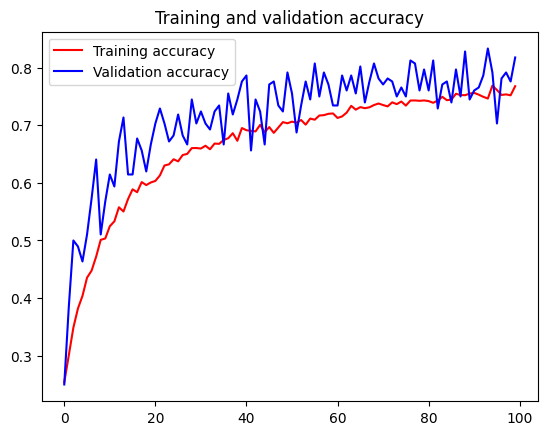

<Figure size 640x480 with 0 Axes>

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Validation

In [36]:
uploaded = ["./data/uploaded/surprise14.jpg"]

img = tf.keras.utils.load_img(
    uploaded[0], target_size=(SHAPE, SHAPE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [37]:
predictions_self = model.predict(img_array)
score = tf.nn.softmax(predictions_self[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[list(class_names.keys())[np.argmax(score)]], 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
This image most likely belongs to 0 with a 31.18 percent confidence.


2022-11-24 10:08:06.166128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.173617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.177691: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.183010: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.188741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.192695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [38]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(img_array)

print(predictions[0])
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 50ms/step
[0.311791  0.1147015 0.1147015 0.1147015 0.1147015 0.1147015 0.1147015]
0


2022-11-24 10:08:06.916838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.925368: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.929384: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.933938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.937394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.939643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-11-24 10:08:06.976145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [39]:
def plot_image(predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(list(class_names.keys())[np.argmax(predicted_label)],
                                100*np.max(predictions_array),
                                list(class_names.keys())[np.argmax(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  plt.grid(False)
  plt.xticks(range(7))
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

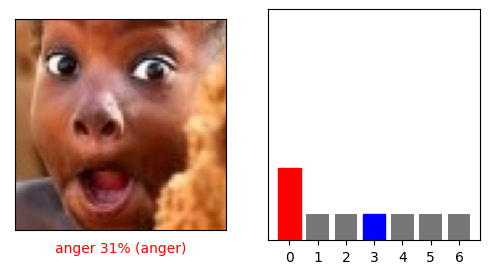

In [40]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(predictions[i], 3, img)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  3)
plt.show()